In [19]:
library(survival)
library(ggplot2)
library(dplyr)
library(reshape2)
library(stringr)

In [20]:
dir_fig = 'R_clogit/for_publish_fin/'

file_dir = 'combined_tables_missing/'

# for LongTR
q_suf = '_Q'

#filter_samples = FALSE
filter_samples = TRUE
#file_sam_missing = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs_LongTR/FAM/variant_prior/tr_missingness/samples_missingness_30.tsv'
#file_sam_missing = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs_LongTR/FAM/variant_prior/tr_missingness/samples_missingness_35.tsv'
#file_sam_missing = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs_LongTR/FAM/variant_prior/tr_missingness/samples_missingness_40.tsv'
file_sam_missing = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/TRs_LongTR/FAM/variant_prior/tr_missingness/samples_missingness_50.tsv'

file_suf_trmissing = '25'
#file_suf_trmissing = '20'
#file_suf_trmissing = '15'

#pca_tr_flt_name = 'ZS3_SUPP3'
pca_tr_flt_name = 'ZS3_SUPP2'

#use_gw_cov = FALSE
use_gw_cov = TRUE
gw_suf = ''
if (use_gw_cov) {
    gw_suf = '_useGWB'
}

In [21]:
### clean features
fts = c('PLIp9_DEV_BR_GENE_10_cds + PLIp9_DEV_BR_GENE_10_utr', 
        'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr', 
        'PLIp9_cds + PLIp9_utr', 
        'LOWPLI_cds + LOWPLI_utr', 
        'genic_cds + genic_utr',

        'PLIp9_DEV_BR_GENE_10_cds',
        'DEV_BR_GENE_10_cds',
        'PLIp9_cds',
        'LOWPLI_cds',
        'genic_cds',

        'PLIp9_DEV_BR_GENE_10_utr',
        'DEV_BR_GENE_10_utr',
        'PLIp9_utr',
        'LOWPLI_utr',
        'genic_utr',

        'PLIp9_DEV_BR_GENE_10_intron',
        'DEV_BR_GENE_10_intron', 
        'PLIp9_intron', 
        'LOWPLI_intron', 
        'genic_intron',
        
        'intergenic', 
        'FB_PR')
fts_labels = c('fetal brain expressed genes with pLI≥.9, exonic', 
               'fetal brain expressed genes, exonic', 
               'pLI≥.9, exonic', 
               'pLI≤.9, exonic', 
               'exonic',

               'fetal brain expressed genes with pLI≥.9, CDS', 
               'fetal brain expressed genes, CDS', 
               'pLI≥.9, CDS', 
               'pLI≤.9, CDS', 
               'CDS',

               'fetal brain expressed genes with pLI≥.9, UTR', 
               'fetal brain expressed genes, UTR', 
               'pLI≥.9, UTR', 
               'pLI≤.9, UTR', 
               'UTR',

               'fetal brain expressed genes with pLI≥.9, intronic',
               'fetal brain expressed genes, intronic', 
               'pLI≥.9, intronic', 
               'pLI≤.9, intronic', 
               'intronic', 
               
               'intergenic', 
               'fetal brain promoter')
fts_cats = c('fetal brain pLI≥.9', 
             'fetal brain',
             'pLI≥.9', 
             'pLI≤.9',
             'genomewide',
             
             'fetal brain pLI≥.9', 
             'fetal brain',
             'pLI≥.9', 
             'pLI≤.9',
             'genomewide',
             
             'fetal brain pLI≥.9', 
             'fetal brain',
             'pLI≥.9', 
             'pLI≤.9',
             'genomewide',
            
             'fetal brain pLI≥.9', 
             'fetal brain',
             'pLI≥.9', 
             'pLI≤.9',
             'genomewide', 
             
             'intergenic', 
             'fetal brain promoter')
fts_func = c('exonic', 
             'exonic',
             'exonic', 
             'exonic', 
             'exonic',
            
             'CDS', 
             'CDS',
             'CDS', 
             'CDS', 
             'CDS',
            
             'UTR', 
             'UTR',
             'UTR', 
             'UTR', 
             'UTR',
             
             'intronic', 
             'intronic',
             'intronic', 
             'intronic', 
             'intronic',
            
             'intergenic', 
             'fetal brain promoter')
fts_col_names = c('fetal_brain_genes_pli_exonic', 
                  'fetal_brain_genes_exonic', 
                  'pli_genes_exonic', 
                  'lowpli_genes_exonic', 
                  'genic_exonic',

                  'fetal_brain_genes_pli_CDS', 
                  'fetal_brain_genes_CDS', 
                  'pli_genes_CDS', 
                  'lowpli_genes_CDS', 
                  'genic_CDS',

                  'fetal_brain_genes_pli_UTR', 
                  'fetal_brain_genes_UTR', 
                  'pli_genes_UTR', 
                  'lowpli_genes_UTR', 
                  'genic_UTR',
                  
                  'fetal_brain_genes_pli_intronic', 
                  'fetal_brain_genes_intronic', 
                  'pli_genes_intronic', 
                  'lowpli_genes_intronic', 
                  'genic_intronic', 
                  
                  'intergenic', 
                  'FB_promoter')

In [22]:
get_pval_char <- function(pval) {
    if (pval>0.05) {return('')}
    if ((pval<0.05) && (pval>0.01)) {return('*')}
    else if ((pval<0.01) && (pval>0.001)) {return('**')}
    else {return('***')}
}

In [23]:
#### prs_mode = 'sbayesr'
prs_mode = 'prscs'
file_suf = 'SQ20_SAMPLES_AD2_SAMPLES'

if (prs_mode == 'sbayesr') {
    file_main = paste0(file_dir, 'combined_svs_trs_snvs_prs_pc_sbayesr_', file_suf, '_DELINS_GW_plat', '_TRmissingness', file_suf_trmissing, '_fltHomPol_famGT.csv')
} else if (prs_mode == 'prscs') {
    file_main = paste0(file_dir, 'combined_svs_trs_snvs_prs_pc_prscs_', file_suf, '_DELINS_GW_plat', '_TRmissingness', file_suf_trmissing, '_fltHomPol_famGT.csv')}

df_main <- read.table(file_main, header = TRUE, sep = ",")
#df_main['count_PLIp9_nonLOF_DEV_BR_10_cds'] = df_main[,'count_PLIp9_DEV_BR_GENE_10_cds'] - df_main[,'count_PLIp9_LOF_DEV_BR_10_cds']
df_main[,'Platform'] <- as.factor(df_main[,'Platform'])
df_main[,'sex'] <- as.factor(df_main[,'sex'])
dim(df_main)
df_main

[1]  243 5571

fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,⋯,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_del,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_ins,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_Q,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_Q_del,count_ZS9_PLIp9_DEV_BR_GENE_10_intron_SUPP3_Q_ins,PRS_ASD_Z,PRS_SCZ_Z,PRS_EDU_Z,count_dnlof_inhlof
<chr>,<chr>,<chr>,<fct>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
F0001,REACH000001,ASD,Male,1,trio,1,1,0.008627126,-0.005607061,⋯,0,0,0,0,0,0,-0.971701072,-0.510485305,0.82162924,0
F0026,REACH000026,ASD,Male,1,trio,1,0,0.095363540,-0.045229620,⋯,0,0,0,0,0,0,0.303644763,0.817056455,0.06312390,1
F0058,REACH000058,ASD,Male,1,trio,1,1,0.002421759,-0.009216429,⋯,0,0,0,0,0,0,0.595643472,-0.305436874,1.94303491,2
F0065,REACH000065,ASD,Male,1,trio,1,0,0.252773800,0.107932900,⋯,0,0,0,0,0,0,1.166191828,0.943709479,-2.78896425,1
F0078,REACH000086,ASD,Male,1,trio,2,0,0.044785250,0.038064880,⋯,0,0,0,0,0,0,0.703902177,-0.152554399,0.06482359,0
F0078,REACH000089,ASD,Female,1,trio,2,0,0.049879690,0.047204300,⋯,0,0,0,0,0,0,0.384605619,0.209070495,0.16440487,0
F0081,REACH000092,ASD,Female,1,trio,1,1,-0.028510680,-0.001001894,⋯,0,0,0,0,0,0,-0.898010204,-0.994547648,0.53088874,1
F0081,REACH000095,CON,Female,1,trio,1,1,-0.030440730,-0.002736118,⋯,0,0,0,0,0,0,-1.036073363,-1.487948561,0.29231934,1
F0083,REACH000097,ASD,Male,1,trio,1,0,0.095793110,0.052887850,⋯,0,0,0,0,0,0,0.817923575,-0.003587407,-0.08546761,1


In [24]:
### subset the main df to filter high missingness TRs
df_sam_missing = read.table(file_sam_missing, header = TRUE, sep = "\t", col.names = c('SAMPLE'))
dim(df_sam_missing)

tmp = unlist(strsplit(file_sam_missing, '_'))
sample_missingness = unlist(strsplit(tmp[[length(tmp)]], '.tsv'))[[1]]
sample_missingness

flt_sam_suff = '_allSamples'
flt_sam_title = 'all samples'
flt_tr_title = paste('TR MS≤', as.double(file_suf_trmissing)/100)
if (filter_samples) {
    flt_sam_suff = paste0('_filterSamples', sample_missingness)
    flt_sam_title = paste('sample MS≤', as.double(sample_missingness)/100)
    # subset samples based on missingness
    df_main <- df_main[df_main$iid %in% df_sam_missing$SAMPLE,]
    # eliminate samples with low family members
    ##t = table(df_main$fid)
    ##df_main['fid_count'] = sapply(df_main$fid, function(x) t[x])
    ##df_main = df_main[df_main$fid_count>=3,]
}
print('df_main dim:')
dim(df_main)

df_main_ont = df_main %>% filter(Platform == 'ONT')
df_main_pb = df_main %>% filter(Platform == 'PB')
print(dim(df_main_ont))
print(dim(df_main_pb))

[1] 209   1

[1] "50"

[1] "df_main dim:"


[1]  209 5571

[1]  101 5571
[1]  108 5571


In [25]:
### TRs All
#PRINT_INFO = TRUE
PRINT_INFO = FALSE
SHOW_FORMULA = TRUE

zs_thr = 3
#zs_thr = 5
#zs_thr = 7
#zs_thr = 9
supp_thr = 2
#supp_thr = 3
#supp_thr = 4
#supp_thr = 5

if (use_gw_cov) {
    gw_var = paste0('count_ZS', zs_thr, '_genomewide_SUPP', supp_thr, '_Q')
    #count_ZS7_genomewide_SUPP2_Q
} 

ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
SEs = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (trs_ft in fts) {
    ft_tmp = unlist(strsplit(trs_ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf, sep="") # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main[ft_]
    }
    var = 'new_var'
    ###print(var) 

    null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', gw_var,
                              '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
    if (SHOW_FORMULA) {
        print(null_formula)
        SHOW_FORMULA = FALSE
    }
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
    
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', gw_var,
                                     '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    SE = summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    SEs = c(SEs, SE)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('SEs:')
    print(SEs)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data_tr = data.frame('fts' = fts, 'fts_labels' = fts_labels, 'fts_cats' = fts_cats, 'fts_func' = fts_func,
                     'log_ORs' = log_ORs, 'log_ORs_plus' = log_ORs_plus, 'log_ORs_minus' = log_ORs_minus, 
                     'ano_pval' = ano_pvals, 'SEs' = SEs,
                     'sum_case_con' = sum_case_controls)

### write burden test tables
sub_fts_out = c('intergenic',
            'LOWPLI_intron', 'LOWPLI_cds + LOWPLI_utr', 
            'PLIp9_intron', 'PLIp9_cds + PLIp9_utr', 
            'DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr')
this_cols = c('fts_labels', 'log_ORs', 'log_ORs_plus', 'log_ORs_minus', 'ano_pval', 'SEs')
new_cols = c('Category', 'log OR', 'upper 95% CI', 'lower 95% CI', 'p-value', 'log OR SE')
this_data_out = my_data_tr[my_data_tr$fts %in% sub_fts_out, this_cols]
# formating the columns with number of digits
for (i_col in 2:length(this_cols)) {
    this_col = this_cols[i_col]
    this_data_out[this_col] = format(this_data_out[this_col], digits = 4, nsmall = 2)
}
colnames(this_data_out) <- new_cols
print(this_data_out)
file_out = paste0(dir_fig, 'burden_tests_table_trs_MEGA.tsv')
print(file_out)
write.table(this_data_out, file = file_out, sep = "\t", row.names = FALSE, quote = FALSE)

[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z + 
    count_ZS3_genomewide_SUPP2_Q + PC1 + PC2 + PC3 + PC4 + PC5 + 
    PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)
[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_cds_SUPP2_Q" "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_ZS3_LOWPLI_cds_SUPP2_Q" "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_ZS3_genic_cds_SUPP2_Q" "count_ZS3_genic_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[1] "count_ZS3_PLIp9_cds_SUPP2_Q"
[1] "count_ZS3_LOWPLI_cds_SUPP2_Q"
[1] "count_ZS3_genic_cds_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_ZS3_genic_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q"

In [26]:
### TRs ONT
#PRINT_INFO = TRUE
PRINT_INFO = FALSE
SHOW_FORMULA = TRUE

ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
SEs = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (trs_ft in fts) {
    ft_tmp = unlist(strsplit(trs_ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf, sep="") # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main_ont
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main_ont[ft_]
    }
    var = 'new_var'
    ###print(var)

    null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', gw_var,
                              '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
    if (SHOW_FORMULA) {
        print(null_formula)
        SHOW_FORMULA = FALSE
    }
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
    
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', gw_var,
                                     '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    SE = summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    SEs = c(SEs, SE)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('SEs:')
    print(SEs)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data_tr_all_ont = cbind(my_data_tr, data.frame('log_ORs_ont' = log_ORs, 'log_ORs_plus_ont' = log_ORs_plus, 'log_ORs_minus_ont' = log_ORs_minus, 
                     'ano_pval_ont' = ano_pvals, 'SEs_ont' = SEs,
                     'sum_case_con_ont' = sum_case_controls))

[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z + 
    count_ZS3_genomewide_SUPP2_Q + PC1 + PC2 + PC3 + PC4 + PC5 + 
    PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)
[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_cds_SUPP2_Q" "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_ZS3_LOWPLI_cds_SUPP2_Q" "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_ZS3_genic_cds_SUPP2_Q" "count_ZS3_genic_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[1] "count_ZS3_PLIp9_cds_SUPP2_Q"
[1] "count_ZS3_LOWPLI_cds_SUPP2_Q"
[1] "count_ZS3_genic_cds_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_ZS3_genic_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q"

In [27]:
### TRs PB
#PRINT_INFO = TRUE
PRINT_INFO = FALSE
SHOW_FORMULA = TRUE

ORs = c()
ORs_plus = c()
ORs_minus = c()
log_ORs = c()
log_ORs_plus = c()
log_ORs_minus = c()
SEs = c()
pvals = c()
ano_pvals = c()
sum_cases = c()
sum_controls = c()
for (trs_ft in fts) {
#for (trs_ft in trs_fts[1:1]) {
    ft_tmp = unlist(strsplit(trs_ft, split='+', fixed=TRUE)) # split vars with +
    ft_tmp = str_trim(ft_tmp) # trim spaces
    ft_tmp = paste('count_ZS', zs_thr, '_', ft_tmp, '_SUPP', supp_thr, q_suf, sep="") # add count_
    print(ft_tmp)
    ### make a new data frame and make a new variable called new_var
    new_df = df_main_pb
    new_df['new_var'] = 0
    for (ft_ in ft_tmp) {
        new_df['new_var'] = new_df['new_var'] + df_main_pb[ft_]
    }
    var = 'new_var'
    ###print(var) 

    null_formula = as.formula(paste('Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', gw_var,
                              '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
    if (SHOW_FORMULA) {
        print(null_formula)
        SHOW_FORMULA = FALSE
    }
    
    sum_case = sum(new_df[new_df$Phenotype==1,][,var])
    sum_control = sum(new_df[new_df$Phenotype==0,][,var])
    sum_cases = c(sum_cases, sum_case)
    sum_controls = c(sum_controls, sum_control)
    
    model_formula = as.formula(paste('Phenotype ~', var, '+ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z +', gw_var,
                                     '+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)'))
        
    null_model <- clogit(null_formula, data = new_df)
    #print(summary(null_model))
    
    clogit_model <- clogit(model_formula, data = new_df)
    #print(summary(clogit_model))
    #print(str(summary(clogit_model)))
    OR = summary(clogit_model)$conf.int[var, 'exp(coef)']
    OR_plus = summary(clogit_model)$conf.int[var, 'upper .95']
    OR_minus = summary(clogit_model)$conf.int[var, 'lower .95']
    log_OR = summary(clogit_model)$coefficients[var, 'coef']
    log_OR_plus = summary(clogit_model)$coefficients[var, 'coef'] + summary(clogit_model)$coefficients[var, 'se(coef)']
    log_OR_minus = summary(clogit_model)$coefficients[var, 'coef'] - summary(clogit_model)$coefficients[var, 'se(coef)']
    SE = summary(clogit_model)$coefficients[var, 'se(coef)']
    pval = summary(clogit_model)$coefficients[var, 'Pr(>|z|)']
    ORs = c(ORs, OR)
    ORs_plus = c(ORs_plus, OR_plus)
    ORs_minus = c(ORs_minus, OR_minus)
    log_ORs = c(log_ORs, log_OR)
    log_ORs_plus = c(log_ORs_plus, log_OR_plus)
    log_ORs_minus = c(log_ORs_minus, log_OR_minus)
    SEs = c(SEs, SE)
    pvals = c(pvals, pval)
        
    ano <- anova(null_model, clogit_model, test='LRT')
    ano_pval = ano$"Pr(>|Chi|)"[2]
    ano_pvals = c(ano_pvals, ano_pval)
}

sum_case_controls = paste(as.character(sum_cases), as.character(sum_controls), sep='/')

if (PRINT_INFO) {
    print('ORs:')
    print(ORs)
    print('ORs_plus:')
    print(ORs_plus)
    print('ORs_minus:')
    print(ORs_minus)
    print('log_ORs:')
    print(log_ORs)
    print('log_ORs_plus:')
    print(log_ORs_plus)
    print('log_ORs_minus:')
    print(log_ORs_minus)
    print('SEs:')
    print(SEs)
    print('pvals:')
    print(pvals)
    print('ano_pvals:')
    print(ano_pvals)
    print('sum_cases:')
    print(sum_cases)
    print('sum_controls:')
    print(sum_controls)
    print('sum_case_controls:')
    print(sum_case_controls)
}

my_data_tr_all_ont_pb = cbind(my_data_tr_all_ont, data.frame('log_ORs_pb' = log_ORs, 'log_ORs_plus_pb' = log_ORs_plus, 'log_ORs_minus_pb' = log_ORs_minus, 
                     'ano_pval_pb' = ano_pvals, 'SEs_pb' = SEs,
                     'sum_case_con_pb' = sum_case_controls))

[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
Phenotype ~ sex + MEAN_COVERAGE + count_dnlof_inhlof + PRS_ASD_Z + 
    count_ZS3_genomewide_SUPP2_Q + PC1 + PC2 + PC3 + PC4 + PC5 + 
    PC6 + PC7 + PC8 + PC9 + PC10 + strata(fid)
[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[2] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_cds_SUPP2_Q" "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_ZS3_LOWPLI_cds_SUPP2_Q" "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_ZS3_genic_cds_SUPP2_Q" "count_ZS3_genic_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_cds_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_cds_SUPP2_Q"
[1] "count_ZS3_PLIp9_cds_SUPP2_Q"
[1] "count_ZS3_LOWPLI_cds_SUPP2_Q"
[1] "count_ZS3_genic_cds_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_DEV_BR_GENE_10_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_utr_SUPP2_Q"
[1] "count_ZS3_LOWPLI_utr_SUPP2_Q"
[1] "count_ZS3_genic_utr_SUPP2_Q"
[1] "count_ZS3_PLIp9_DEV_BR_GENE_10_intron_SUPP2_Q"

In [28]:
my_data_tr_all_ont_pb['wt_ont'] = 1 / (my_data_tr_all_ont_pb$SEs_ont^2)
my_data_tr_all_ont_pb['wt_pb'] = 1 / (my_data_tr_all_ont_pb$SEs_pb^2)
my_data_tr_all_ont_pb['se_meta'] = sqrt(1 / (my_data_tr_all_ont_pb['wt_ont'] + my_data_tr_all_ont_pb['wt_pb']))
my_data_tr_all_ont_pb['log_ORs_meta'] = ((my_data_tr_all_ont_pb['log_ORs_ont']*my_data_tr_all_ont_pb['wt_ont'] + 
                                          my_data_tr_all_ont_pb['log_ORs_pb']*my_data_tr_all_ont_pb['wt_pb']) / 
                                         (my_data_tr_all_ont_pb['wt_ont'] + my_data_tr_all_ont_pb['wt_pb']))
my_data_tr_all_ont_pb['log_ORs_plus_meta'] = my_data_tr_all_ont_pb['log_ORs_meta'] + my_data_tr_all_ont_pb['se_meta']
my_data_tr_all_ont_pb['log_ORs_minus_meta'] = my_data_tr_all_ont_pb['log_ORs_meta'] - my_data_tr_all_ont_pb['se_meta']
my_data_tr_all_ont_pb['Z_meta'] = my_data_tr_all_ont_pb['log_ORs_meta'] / my_data_tr_all_ont_pb['se_meta']
my_data_tr_all_ont_pb = my_data_tr_all_ont_pb[!is.na(my_data_tr_all_ont_pb['Z_meta']),]
my_data_tr_all_ont_pb['ano_pval_meta'] = sapply(my_data_tr_all_ont_pb['Z_meta'], function(x) 2 * (1 - pnorm(abs(x))))
#my_data_tr_all_ont_pb['ano_pval_meta'] = sapply(my_data_tr_all_ont_pb['Z_meta'], function(x) 2*pnorm(-1*abs(x)))

In [29]:
### write burden test table
sub_fts_out = c('intergenic',
            'LOWPLI_intron', 'LOWPLI_cds + LOWPLI_utr', 
            'PLIp9_intron', 'PLIp9_cds + PLIp9_utr', 
            'DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr')
this_cols = c('fts_labels', 'log_ORs_meta', 'log_ORs_plus_meta', 'log_ORs_minus_meta', 'ano_pval_meta', 'se_meta')
new_cols = c('Category', 'log OR', 'upper 95% CI', 'lower 95% CI', 'p-value', 'log OR SE')
this_data_out = my_data_tr_all_ont_pb[my_data_tr_all_ont_pb$fts %in% sub_fts_out, this_cols]
# formating the columns with number of digits
for (i_col in 2:length(this_cols)) {
    this_col = this_cols[i_col]
    this_data_out[this_col] = format(this_data_out[this_col], digits = 4, nsmall = 2)
}
colnames(this_data_out) <- new_cols
print(this_data_out)
file_out = paste0(dir_fig, 'burden_tests_table_trs_META.tsv')
print(file_out)
write.table(this_data_out, file = file_out, sep = "\t", row.names = FALSE, quote = FALSE)

                                Category    log OR upper 95% CI lower 95% CI
2    fetal brain expressed genes, exonic  0.524832      0.81074     0.238928
3                         pLI≥.9, exonic  0.127917      0.31998    -0.064142
4                         pLI≤.9, exonic  0.216278      0.36416     0.068392
17 fetal brain expressed genes, intronic -0.003183      0.07678    -0.083140
18                      pLI≥.9, intronic -0.053320      0.01458    -0.121216
19                      pLI≤.9, intronic  0.060112      0.11726     0.002959
21                            intergenic  0.035132      0.07483    -0.004570
   p-value log OR SE
2   0.0664   0.28590
3   0.5054   0.19206
4   0.1436   0.14789
17  0.9682   0.07996
18  0.4323   0.06790
19  0.2929   0.05715
21  0.3762   0.03970
[1] "R_clogit/for_publish_fin/burden_tests_table_trs_META.tsv"


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


[1] "R_clogit/for_publish_fin/TRs_burden_ZS3_SUPP2_filterSamples50_TRmissing25_useGWB_META_platform.png"
[1] "R_clogit/for_publish_fin/TRs_burden_ZS3_SUPP2_filterSamples50_TRmissing25_useGWB_META_main.png"


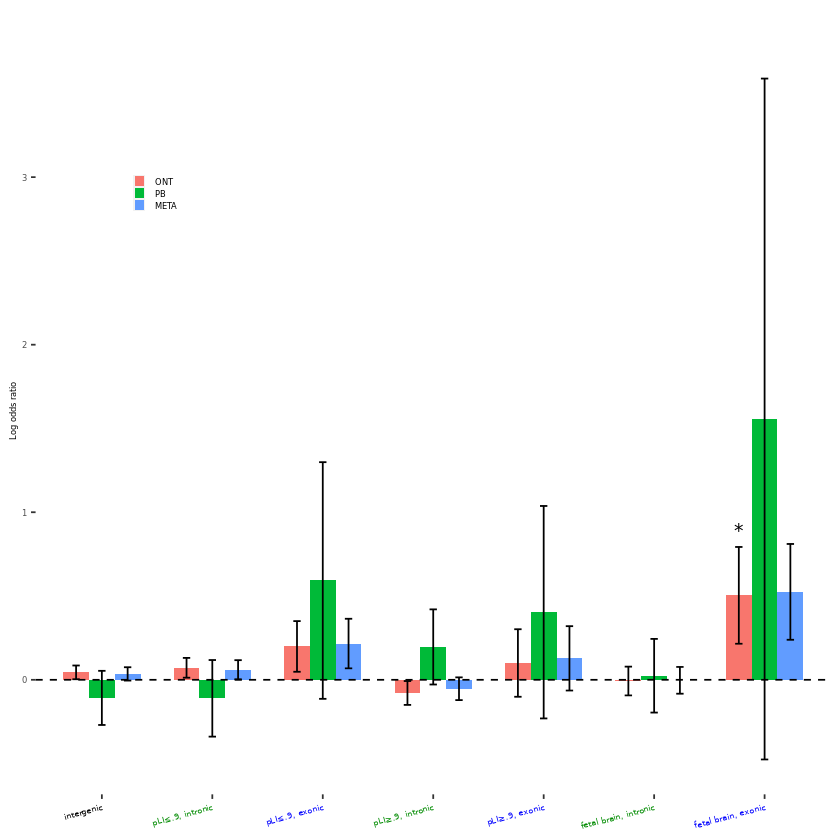

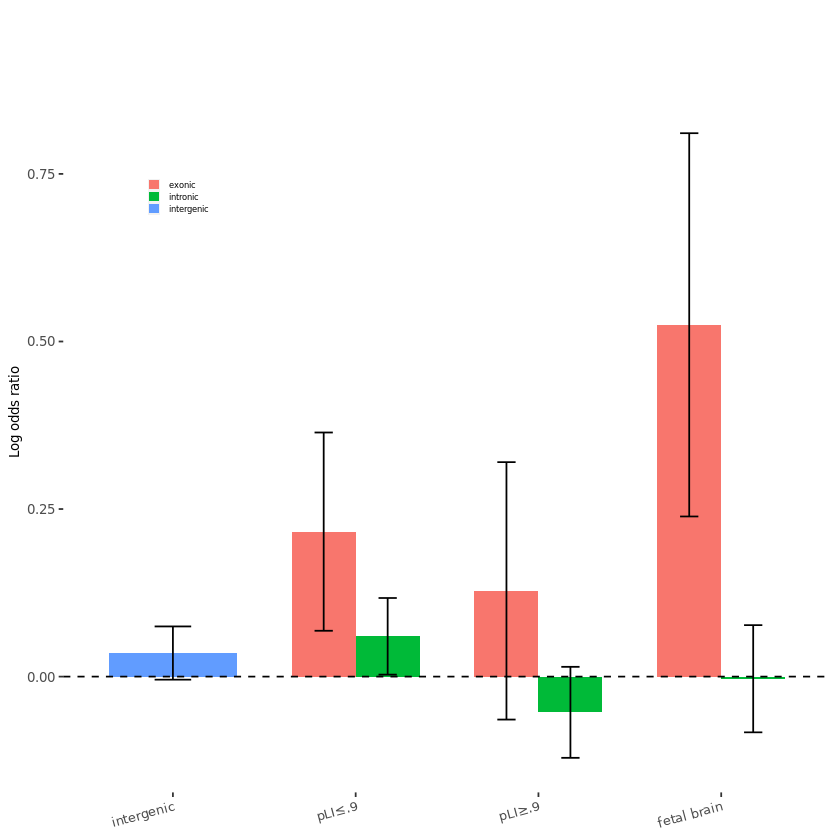

In [30]:
# plot TRs (meta), platform
sub_fts_labels = c('intergenic',
                   'pLI≤.9, intronic', 'pLI≤.9, exonic', 
                   'pLI≥.9, intronic', 'pLI≥.9, exonic', 
                   'fetal brain, intronic', 'fetal brain, exonic')
sub_fts = c('intergenic',
            'LOWPLI_intron', 'LOWPLI_cds + LOWPLI_utr', 
            'PLIp9_intron', 'PLIp9_cds + PLIp9_utr', 
            'DEV_BR_GENE_10_intron', 'DEV_BR_GENE_10_cds + DEV_BR_GENE_10_utr')
color_vec = c('black', 'green4', 'blue',  'green4', 'blue', 'green4', 'blue')
sub_fts_cats = c('intergenic', 'pLI≤.9', 'pLI≥.9', 'fetal brain')
sub_fts_func = c('exonic', 'intronic', 'intergenic')

fig_base = paste0('TRs_burden_', 'ZS', zs_thr, '_SUPP', supp_thr, flt_sam_suff, '_TRmissing', file_suf_trmissing, gw_suf)
title = ''

my_data_sub = my_data_tr_all_ont_pb[my_data_tr_all_ont_pb$fts %in% sub_fts,]
my_data_sub$fts <- factor(my_data_sub$fts, levels = sub_fts)
my_data_sub$fts_cats <- factor(my_data_sub$fts_cats, levels = sub_fts_cats)
my_data_sub$fts_func <- factor(my_data_sub$fts_func, levels = sub_fts_func)

my_data_sub.melt = melt(my_data_sub, id.vars = c('fts', 'fts_labels', 'fts_cats', 'fts_func',
                                                 # adding to bypass mega analysis
                                                 'log_ORs',
                                                 'log_ORs_plus', 'log_ORs_minus', 
                                                 'ano_pval', 
                                                 'sum_case_con', 
                                                 'log_ORs_plus_ont', 'log_ORs_minus_ont', 
                                                 'ano_pval_ont', 
                                                 'sum_case_con_ont',
                                                 'log_ORs_plus_pb', 'log_ORs_minus_pb', 
                                                 'ano_pval_pb', 
                                                 'sum_case_con_pb', 
                                                 'SEs', 'SEs_ont', 'SEs_pb',
                                                 'log_ORs_plus_meta', 'log_ORs_minus_meta', 
                                                 'wt_ont', 'wt_pb', 'se_meta', 'Z_meta', 'ano_pval_meta'), 
                        variable.name = 'lor_type', value.name = 'log_ORs_melt')

lor_type_levels = c('log_ORs_ont', 'log_ORs_pb', 'log_ORs_meta')
my_data_sub.melt$lor_type = factor(my_data_sub.melt$lor_type, levels = lor_type_levels)

my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_plus = ifelse(lor_type=='log_ORs', log_ORs_plus,
                                                                             ifelse(lor_type=='log_ORs_ont', log_ORs_plus_ont, 
                                                                                           ifelse(lor_type=='log_ORs_pb', log_ORs_plus_pb, 
                                                                                                  ifelse(lor_type=='log_ORs_meta', log_ORs_plus_meta, '.')))))
my_data_sub.melt[,'log_ORs_plus'] <- as.double(my_data_sub.melt[,'log_ORs_plus'])

my_data_sub.melt <- transform(my_data_sub.melt, log_ORs_minus = ifelse(lor_type=='log_ORs', log_ORs_minus,
                                                                             ifelse(lor_type=='log_ORs_ont', log_ORs_minus_ont, 
                                                                                           ifelse(lor_type=='log_ORs_pb', log_ORs_minus_pb, 
                                                                                                  ifelse(lor_type=='log_ORs_meta', log_ORs_minus_meta, '.')))))
my_data_sub.melt[,'log_ORs_minus'] <- as.double(my_data_sub.melt[,'log_ORs_minus'])

my_data_sub.melt <- transform(my_data_sub.melt, ano_pval = ifelse(lor_type=='log_ORs', ano_pval,
                                                                             ifelse(lor_type=='log_ORs_ont', ano_pval_ont, 
                                                                                           ifelse(lor_type=='log_ORs_pb', ano_pval_pb, 
                                                                                                  ifelse(lor_type=='log_ORs_meta', ano_pval_meta, '.')))))
my_data_sub.melt[,'ano_pval'] <- as.double(my_data_sub.melt[,'ano_pval'])

sig <- sapply(my_data_sub.melt$ano_pval, get_pval_char)
my_data_sub.melt$sig = sig

size_txt = 8
size_sig = 4
ylim_min = -0.1
ylim_max = 1.5

w1 = 0.7 # was 0.7
w2 = 0.2 # was 0.2

fig_name = paste0(dir_fig, fig_base, "_META_platform.png")

base <- ggplot(my_data_sub.melt, aes(x = fts, y = log_ORs_melt, fill = lor_type, ymin=log_ORs_minus , ymax=log_ORs_plus)) +
  geom_bar(position = position_dodge(width=w1), stat = "identity", width = w1) +
  geom_errorbar(position = position_dodge(width=w1), aes(ymin = log_ORs_minus, ymax = log_ORs_plus), width = w2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  geom_text(aes(label = sig, y = log_ORs_plus+0.1), position=position_dodge(width=w1), angle=0, hjust=0.5, vjust=0.5, size=size_sig) +
  labs(y = "Log odds ratio", title = title) +
  theme(axis.text=element_text(size=size_txt-3),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1., size=size_txt-3, color=color_vec),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size=size_txt-3),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5, size=size_txt-3), 
        legend.position = c(.15, .8),
        legend.text = element_text(size=size_txt-3),
        #legend.title = element_text(size=size_txt),
        legend.key.height = unit(0.1, "in"),         # Adjust legend key height
        legend.key.width = unit(0.1, "in")           # Adjust legend key width
        #plot.margin = margin(20, 110, 20, 80) # Add margins: top, right, bottom, left (in points)
        ) +
  scale_x_discrete(limits=sub_fts, labels=sub_fts_labels) +
  scale_fill_discrete(name = '', labels = c("ONT", "PB", "META"))

print(fig_name)
print(base)
ggsave(fig_name, width = 2.5, height = 1.75, dpi = 1200, units = "in")

########################### main figure ###########################
fig_name = paste0(dir_fig, fig_base, "_META_main.png")

this_data = my_data_sub
sig <- sapply(this_data$ano_pval_meta, get_pval_char)
this_data$sig = sig

base <- ggplot(this_data, aes(x = fts_cats, y = log_ORs_meta, fill = fts_func, ymin=log_ORs_minus_meta , ymax=log_ORs_plus_meta)) +
  geom_bar(position = position_dodge(width=w1), stat = "identity", width = w1) +
  geom_errorbar(position = position_dodge(width=w1), aes(ymin = log_ORs_minus_meta, ymax = log_ORs_plus_meta), width = w2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  geom_text(aes(label = sig, y = log_ORs_plus_meta+0.1), position=position_dodge(width=w1), angle=0, hjust=0.5, vjust=0.5, size=size_sig) +
  labs(y = "Log odds ratio", title = title) +
  theme(axis.text=element_text(size=size_txt),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1., size=size_txt),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size=size_txt),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5, size=size_txt), 
        legend.position = c(.15, 0.8),
        legend.text = element_text(size=size_txt-3),
        #legend.title = element_text(size=size_txt),
        legend.key.height = unit(0.1, "in"),         # Adjust legend key height
        legend.key.width = unit(0.1, "in")           # Adjust legend key width
        #plot.margin = margin(20, 120, 20, 80) # Add margins: top, right, bottom, left (in points)
        ) +
  scale_fill_discrete(name = '')

print(fig_name)
print(base)
ggsave(fig_name, width = 2.5, height = 1.75, dpi = 1200, units = "in")